In [238]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../bone-age-code').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import torch
from torch.utils.data import DataLoader
from dataset import split_dataset, BoneAgeDataset, normalize_target
from transforms import get_transform
from model import m46
import train

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from IPython.core.display import Image, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Downloading the dataset
-----------------------------------

In [ ]:
!! [ ! -f ../data/bone-age.zip ] && wget http://data.neu.ro/bone-age.zip -O ../data/bone-age.zip

In [ ]:
!! [ ! -d ../data/bone-age ] && unzip ../data/bone-age.zip -d ../data

## Explore the data

In [10]:
data_path = Path('../data').absolute()
annotations_path = data_path / 'train.csv'
bone_age_frame = pd.read_csv(annotations_path) # ground truth
image_root = data_path / 'train' # radigraphs root

* ### Analize gender distribution

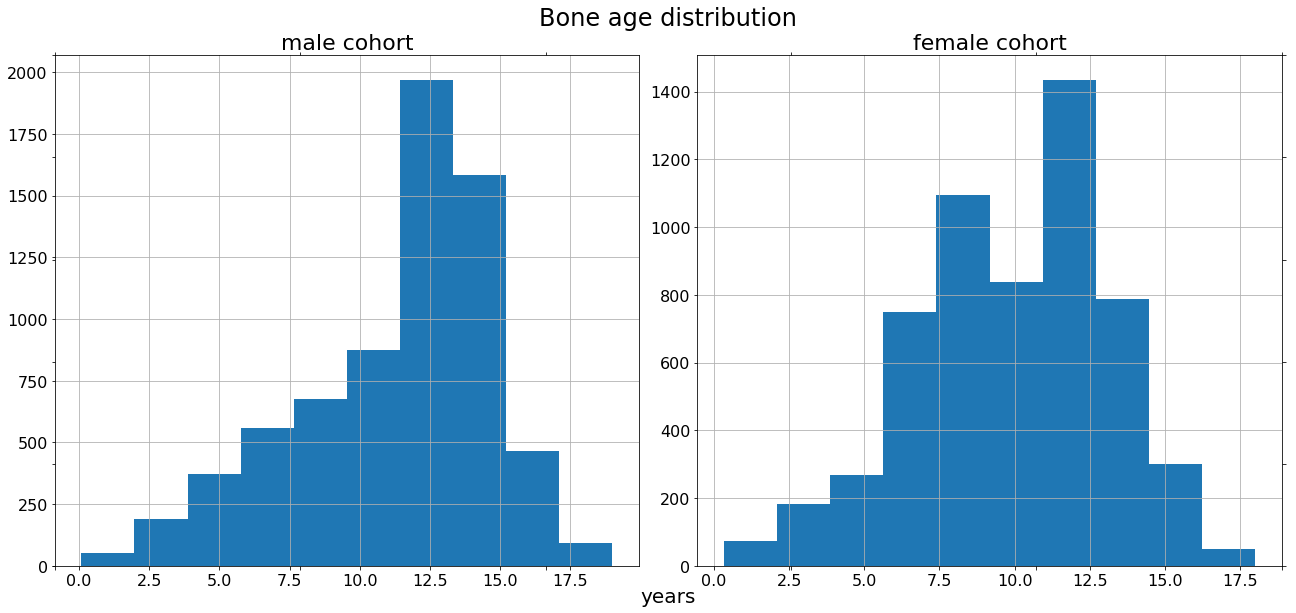

In [7]:
bone_age_frame['boneage_years'] = bone_age_frame['boneage'] / 12
fig = plt.figure(figsize=(18, 8))
for i, gender in enumerate(['male', 'female'], 1):
    ax = plt.subplot(1, 2, i)
    bone_age_frame.loc[bone_age_frame['male'] == (gender == 'male')].hist('boneage_years', ax=ax)
    ax.set_title(f'{gender} cohort', fontsize=22)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
plt.tight_layout()
ax = fig.add_subplot(111, frameon=False)
ax.set_title('Bone age distribution', pad=30, fontsize=24)
ax.set_xlabel('years', fontsize=20)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

* ### Plot some radiographs

In [304]:
def plot_radiographs(dataset, nimages, predictions=None):
    ncols = 4
    nrows = int(np.ceil(nimages / ncols))
    fig = plt.figure()
    for i, sample in enumerate(islice(dataset, nimages), 1):
        image, label, img_id = sample['image'], sample['label'], sample['id']
        if torch.is_tensor(image):
            image = np.squeeze(image.numpy())
            label = normalize_target(label.item(), reverse_norm=True)

        ax = plt.subplot(nrows, ncols, i)
        if predictions is not None:
            ax.set_title(f'id {img_id}, true {label:n}, pred {int(predictions[i - 1]):n}', fontsize=24)
        else:
            ax.set_title(f'id {img_id}, {label:n} months', fontsize=24)
        ax.axis('off')
        ax.imshow(image, cmap='Greys_r')

    figsize = 6
    aspect_ratio = image.shape[0] / image.shape[1]
    fig.set_figheight(aspect_ratio * nrows * figsize)
    fig.set_figwidth(ncols * figsize)
    plt.tight_layout()
    
    ax = fig.add_subplot(111, frameon=False)
    crop_sz = 'x'.join(map(str, image.shape))
    ax.set_title(f'Crop size {crop_sz}', pad=40, fontsize=28)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.pause(0.001)
    plt.show()

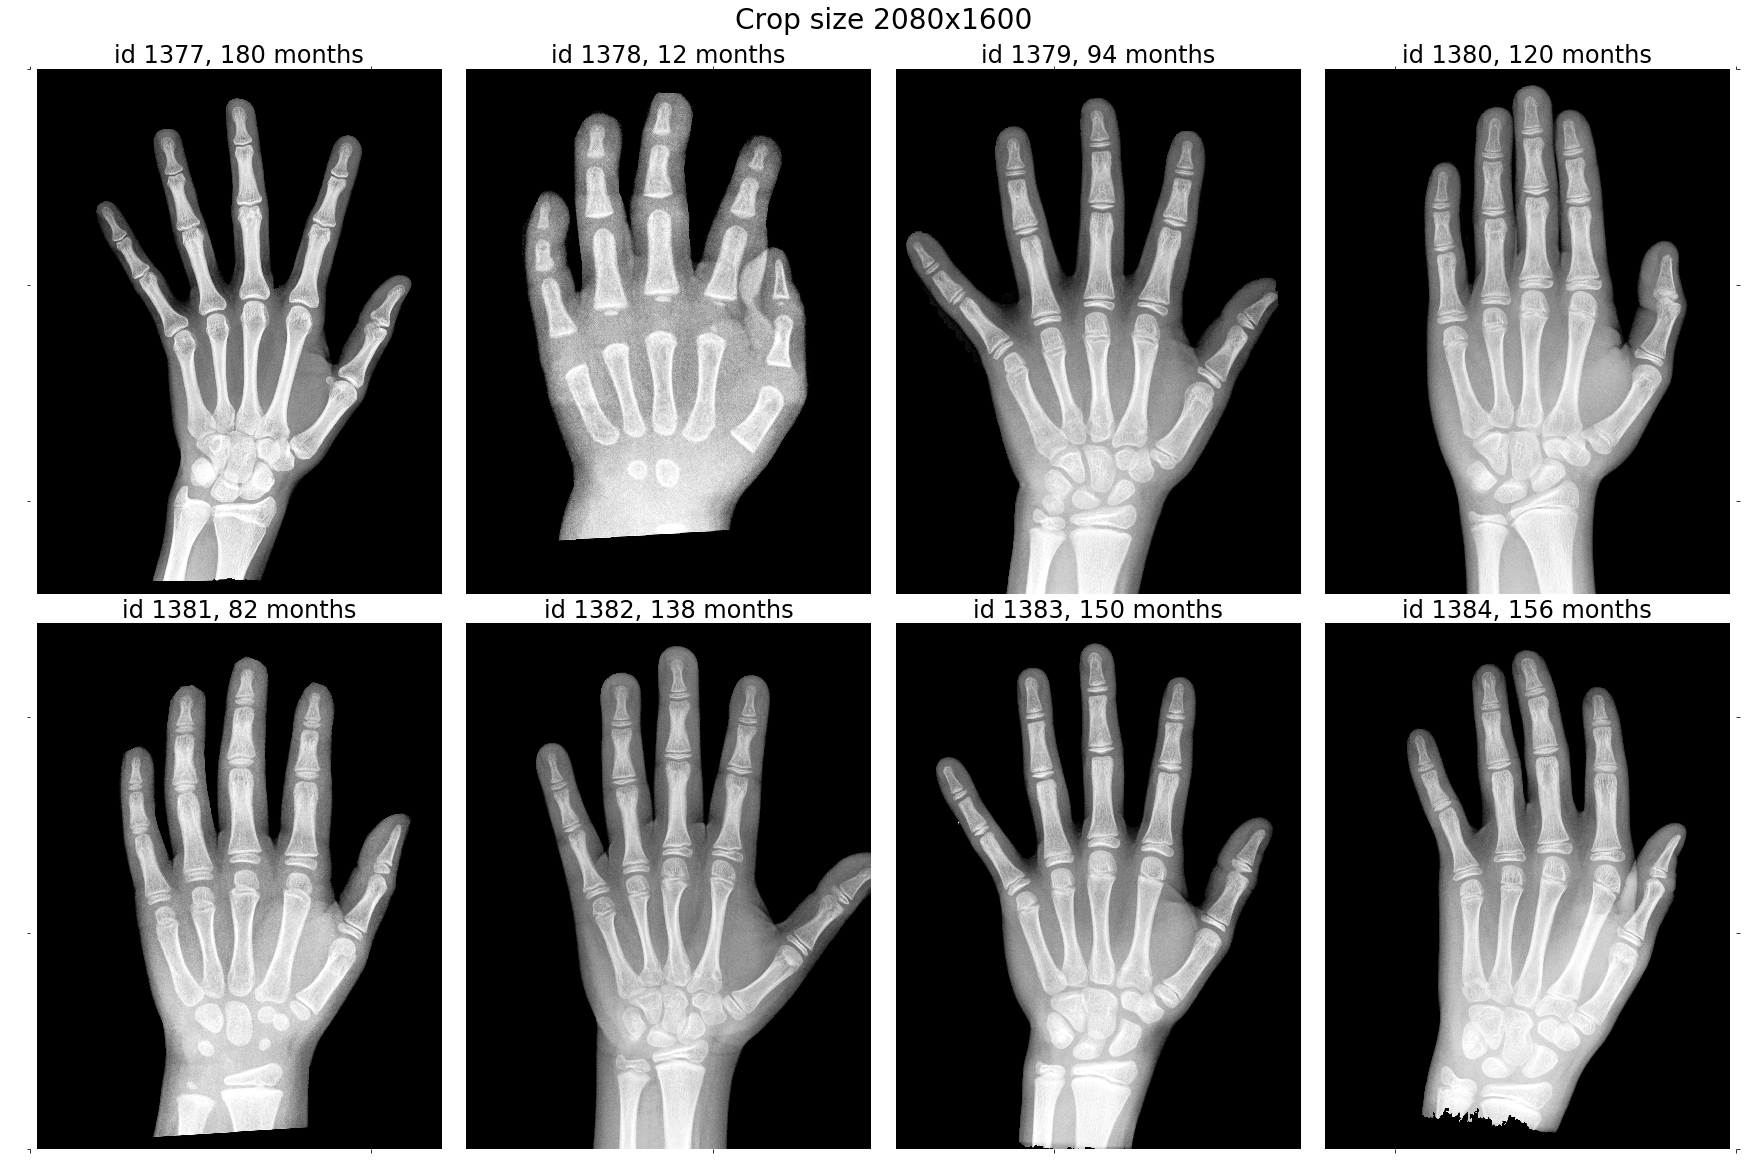

In [312]:
# the preprocessed data is scaled to 2080x1600 (HxW)
boneage_dataset = BoneAgeDataset(bone_age_frame=bone_age_frame, root=image_root, transform=None)

nimages = 8
plot_radiographs(boneage_dataset, nimages)

* ### Familiarize yourself with dataset augmentation

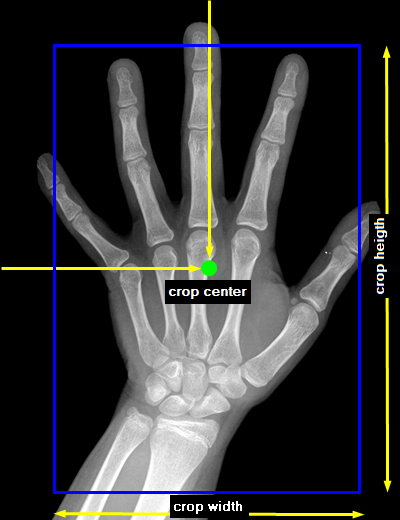

In [12]:
display(Image(data_path / '1396_crop_area.png', width=400, unconfined=True))

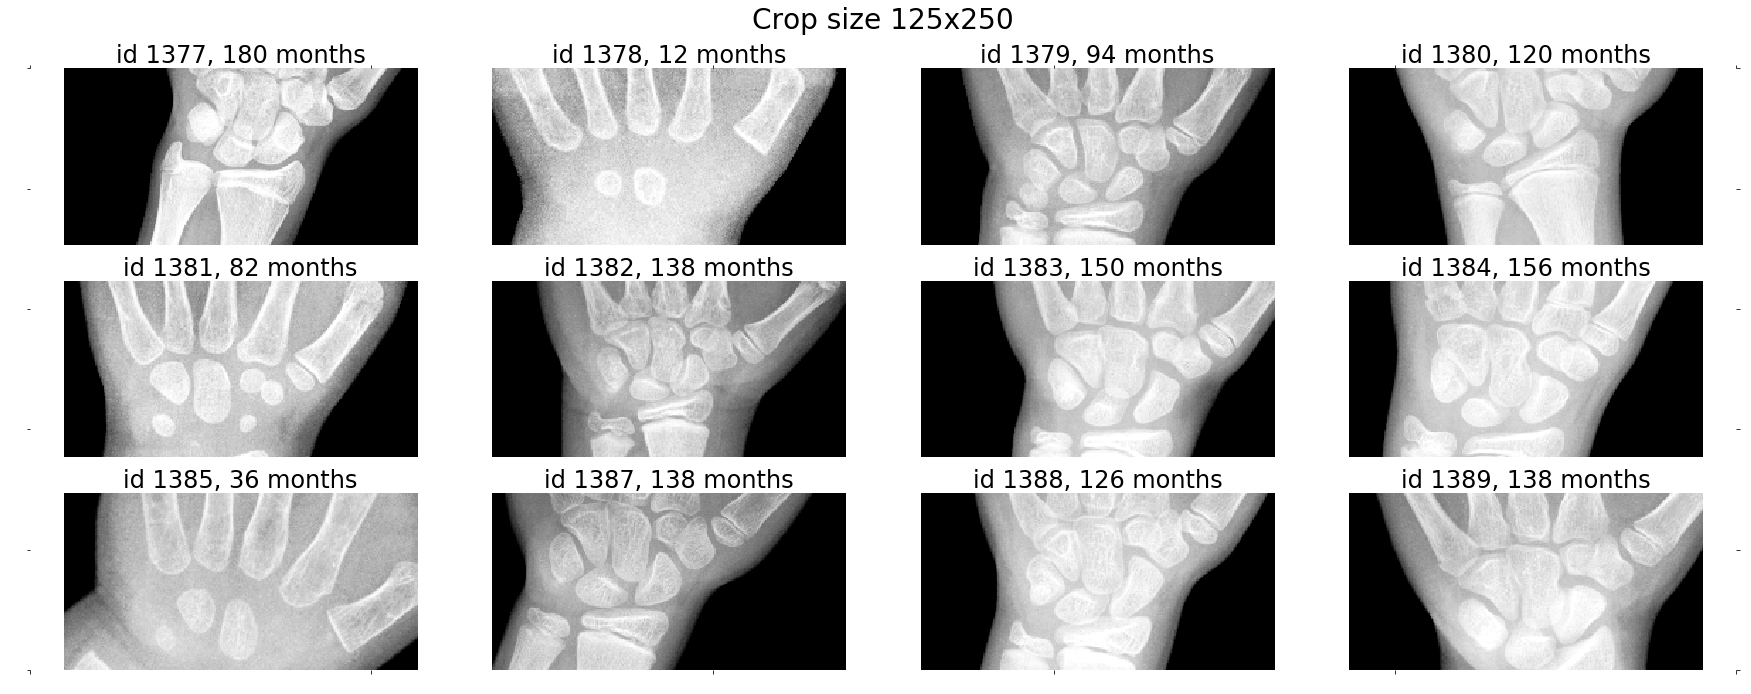

In [306]:
# With `get_transform` function we extract cropped, rescaled and augmented regions of interest
# This allows us to experiment with different areas of a radiograph. See the paper referenced in README
# We also normalize labels by demeaning and rescaling to (120, 120), see `normalize_target` function

# Let's crop just wrist area
crop_center = (1600, 800)
crop_size = (500, 1000)
scale = 0.25
crop_dict = {'crop_center': crop_center, 'crop_size': crop_size}
train_transform = get_transform(augmentation=True, crop_dict=crop_dict, scale=scale)

boneage_dataset = BoneAgeDataset(bone_age_frame=bone_age_frame, root=image_root,
                                 transform=train_transform, target_transform=normalize_target)
nimages = 12
plot_radiographs(boneage_dataset, nimages)

## Train Bone Age model

In [14]:
# Crop most of the radigraph area and scale it with factor 0.25
# Notice that we use normalized targets. For example, loss=0.06 corresponds to error 7.2 months

crop_center = (1040, 800)
h, w = 2000, 1500
scale = 0.25
input_shape = (1, int(h * scale), int(w * scale))
crop_dict = {'crop_center': crop_center, 'crop_size': (h, w)}
preprocess_args = {
    'crop_dict': crop_dict,
    'scale': scale,
    'input_shape': (1, int(h * scale), int(w * scale)) # shape of the model input [CxHxW]
}

dataset_split = (1, 10) # split dataset into 10 folds and use the 1st fold for evaluation and 2-10 for training
model_save_dir = Path('../models').absolute()
prev_ckpt = None # train model from scratch
n_epoch = 2
batch_size = 8
n_gpu = 1
n_workers = 0 # you will probably need to set it to 0 for Jupyter notebook run on Windows

print('Input shape', 'x'.join(map(str, preprocess_args['input_shape'])), '[CxHxW]')

train.main(
    data_dir=image_root,
    preprocessing_args=preprocess_args,
    annotation_csv=annotations_path,
    dataset_split=dataset_split,
    prev_ckpt=prev_ckpt,
    model_save_dir=model_save_dir,
    n_epoch=n_epoch,
    batch_size=batch_size,
    n_gpu=n_gpu,
    n_workers=n_workers
)

Input shape 1x500x375 [CxHxW]
Starting Training Loop...
Epoch 1/2
---------
Train loss: 0.2614
Eval loss: 0.2672
New accuracy reached. Model saved.

Epoch 2/2
---------
Train loss: 0.1941
Eval loss: 0.3708

Done training


## Evaluate Bone Age model on test data

In [311]:
# Decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

# Load pretrained model
crop_center = (1040, 800)
h, w = 2000, 1500
scale = 0.25
input_shape = (1, int(h * scale), int(w * scale))
crop_dict = {'crop_center': crop_center, 'crop_size': (h, w)}

model = m46(input_shape, n_gpu).to(device)
prev_ckpt = Path('../models').absolute() / 'boneage.epoch36-err0.059.pth'
model.load_state_dict(torch.load(prev_ckpt))
print('Model loaded from', prev_ckpt)

test_frame = pd.read_csv(data_path / 'test.csv') # ground truth
test_root =  data_path / 'test'

test_transform = get_transform(augmentation=False, crop_dict=crop_dict, scale=scale)
test_dataset = BoneAgeDataset(bone_age_frame=test_frame, root=test_root, transform=test_transform,
                              target_transform=normalize_target)
data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
loss, labels = train.evaluate(model, data_loader, device)

Model loaded from F:\Sandbox\ml-recipe-bone-age\notebooks\..\models\boneage.epoch36-err0.059.pth
Eval loss: 0.0634


Mean absolute error 7.61 months.


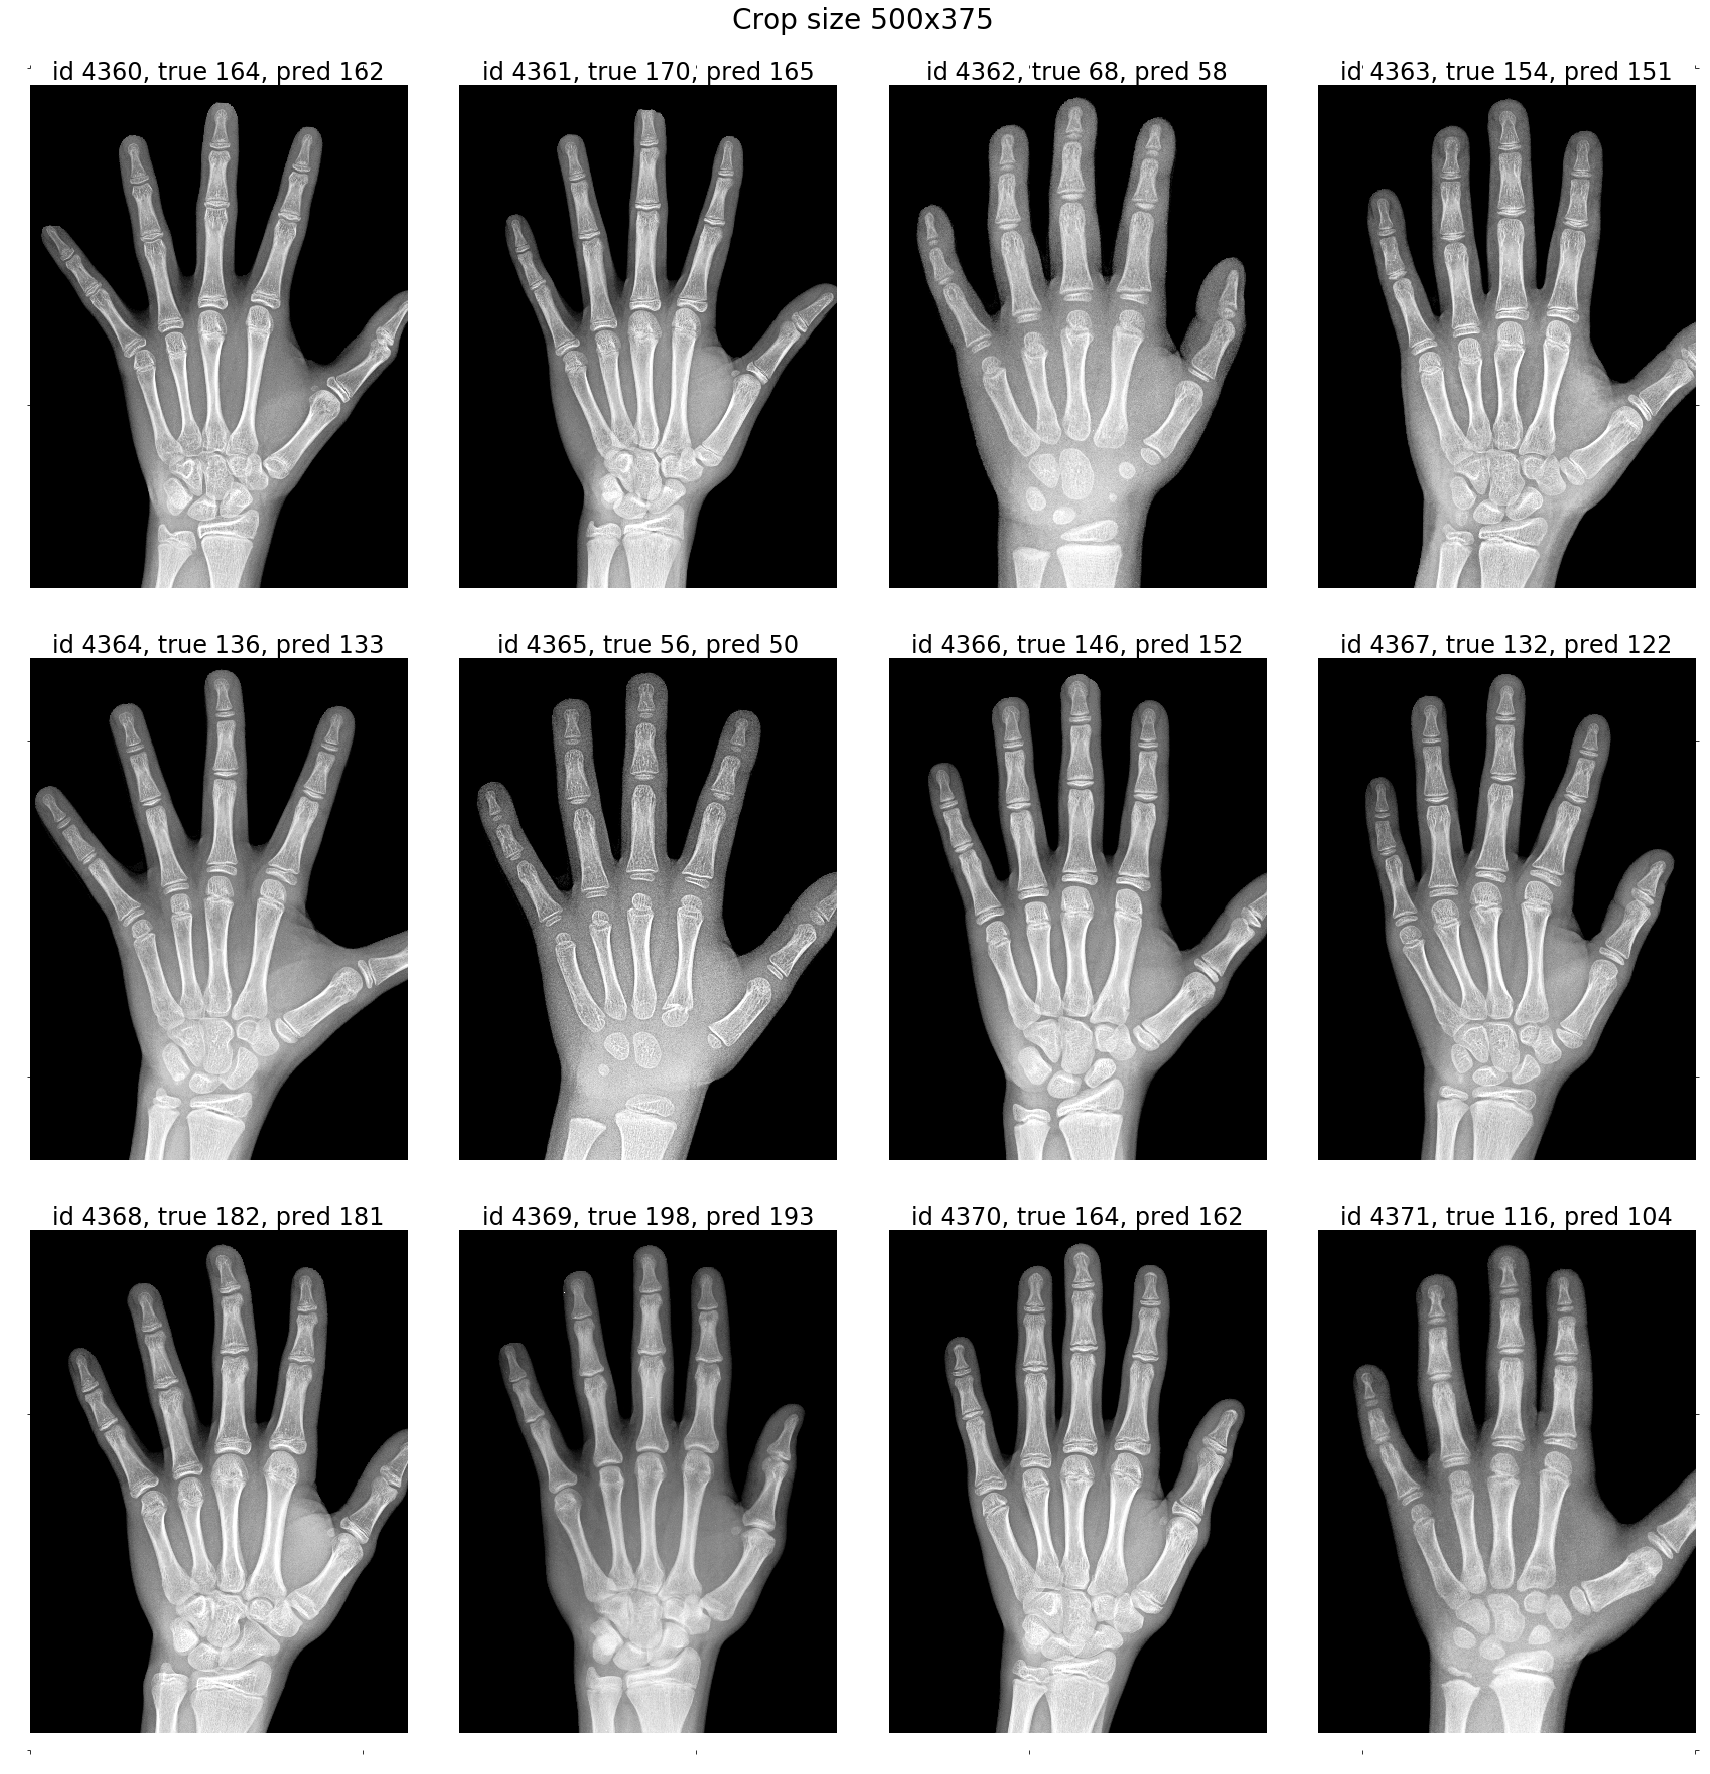

In [318]:
# Plot some predictions

predicted_labels = 120 * (1 + labels['predictions'].flatten())
true_labels = test_frame['boneage'].array
mae = np.abs(true_labels - predicted_labels).mean()
print(f'Mean absolute error {mae:0.2f} months.', )

nimages = 12
plot_radiographs(test_dataset, nimages, predictions=predicted_labels)